In [116]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy import arange

# Number of passengers per histogram

In [2]:
data = {1: 0.63, 2: 0.28, 3: 0.06, 4: 0.02,
                             5: 0.01}

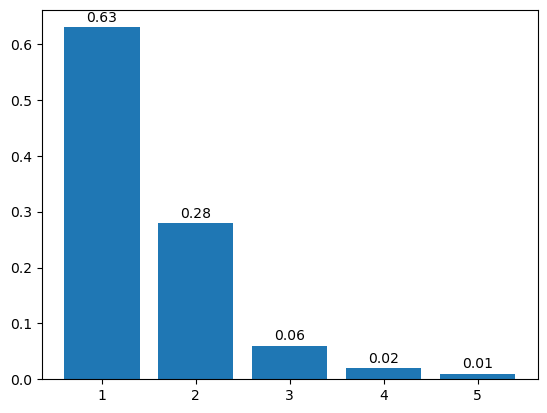

In [3]:
# plot the data and present the values over the bars
fig, ax = plt.subplots()
ax.bar(data.keys(), data.values())
for i, v in data.items():
    ax.text(i, v + 0.01, str(v), color='black', ha='center')
plt.show()

# Create the AV-HD comparison table

In [194]:
df = pd.read_pickle(r"C:\PTL\results\output_results\network_simple\DailyTypes\timeLoss_vType.pkl")
av_rates = [round(rate,1) for rate in arange(0.1, 1.0, 0.1)]
rel_cols = [c for c in df.columns if "mean" in c and c[1] in av_rates]
zero_cols = [c for c in df.columns if "mean" in c and c[1] == 0.0]

In [196]:
zero_df = pd.DataFrame(df[zero_cols].loc["Nothing"]).reset_index()
temp_df = pd.DataFrame(df[rel_cols].loc["OneVariableControl_ptl_speed_20_24_60"]).reset_index()
temp_df.columns = ["Demand","av_rate","vType","stam","APTD"]
zero_df.columns = ["Demand","av_rate","vType","stam","APTD"]
temp_df = pd.concat([zero_df,temp_df])
temp_df.drop(["stam"],inplace=True,axis=1)
temp_df["vType"] = temp_df["vType"].apply(lambda x: x.split("_")[0] if "HD" in x else x)
temp_df = temp_df.groupby(["Demand","av_rate","vType"]).mean().reset_index()
temp_df.dropna(inplace=True)
temp_df.reset_index(drop=True,inplace=True)

In [198]:
new_df = pd.DataFrame()
for demand in temp_df["Demand"].unique():
    for vType in temp_df["vType"].unique():
        temp = temp_df[(temp_df["Demand"]==demand) & (temp_df["vType"]==vType)]
        temp = temp.set_index("av_rate").drop(["Demand","vType"],axis=1).T
        temp["Demand"] = demand
        temp["vType"] = vType
        new_df = pd.concat([new_df,temp])
new_df["numPass"] = new_df["vType"].apply(lambda x: x.split("_")[1] if "AV" in x else None)
new_df["vType"] = new_df["vType"].apply(lambda x: x.split("_")[0])
new_df = new_df[["Demand","vType","numPass"]+[0.0]+av_rates].reset_index(drop=True)

In [201]:
new_df.to_excel("AV-HD_comparison.xlsx")

# Create the APTD improvement against baseline figure for OneVariableControl_ptl_speed_20_24_60

In [45]:
df = pd.read_pickle(r"C:\PTL\results\output_results\network_simple\DailyTypes\passDelay_baseline.pkl")
df = df.loc["OneVariableControl_ptl_speed_23_24_60"]

In [46]:
df_new = df.reset_index()
df_new.columns = ["Demand","av_rate","mean/std","APTD"]
df_new = df_new[df_new["av_rate"]!=0.0]

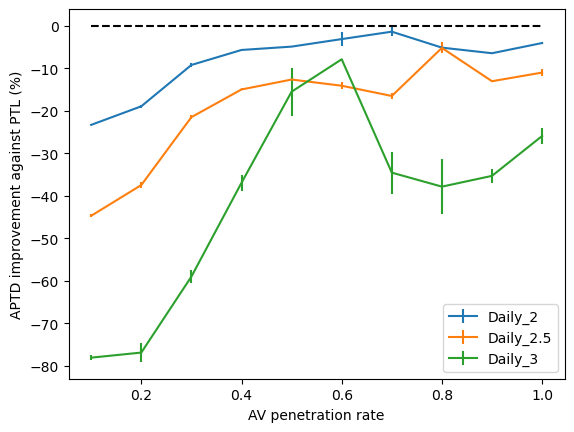

In [47]:
# plot the improvement, each demand is a different line. create error bars for each point using the std
fig, ax = plt.subplots()
for demand in df_new["Demand"].unique():
    temp = df_new[df_new["Demand"]==demand]
    means = temp[temp["mean/std"] == "mean"]["APTD"]
    stds = temp[temp["mean/std"] == "std"]["APTD"]
    av_rates = temp[temp["mean/std"] == "mean"]["av_rate"]
    ax.errorbar(av_rates,means,yerr=stds/np.sqrt(10),label=demand)
plt.xlabel("AV penetration rate")
plt.ylabel("APTD improvement against PTL (%)")
plt.plot([0.1,1.0],[0,0],color="black",linestyle="--")
plt.legend()
plt.show()

# Create the APTD improvement FOR DAILY 12

In [145]:
df = pd.read_pickle(r"C:\PTL\results\output_results\network_simple\Daily12\passDelay_baseline.pkl")
df = df.loc["OneVariableControl_threshold_ptl_speed_24.0_60"]

In [146]:
df_new = df.reset_index()
df_new.columns = ["Demand","av_rate","mean/std","APTD"]
df_new = df_new[df_new["av_rate"]!=0.0]

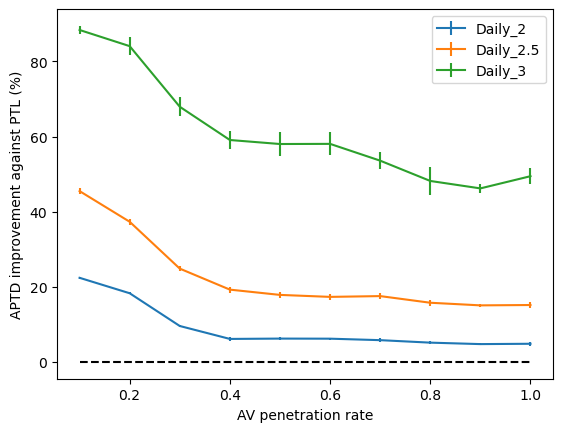

In [147]:
# plot the improvement, each demand is a different line. create error bars for each point using the std
fig, ax = plt.subplots()
for demand in df_new["Demand"].unique():
    temp = df_new[df_new["Demand"]==demand]
    means = -temp[temp["mean/std"] == "mean"]["APTD"]
    stds = temp[temp["mean/std"] == "std"]["APTD"]
    av_rates = temp[temp["mean/std"] == "mean"]["av_rate"]
    ax.errorbar(av_rates,means,yerr=stds/np.sqrt(10),label=demand.replace("12",""))
plt.xlabel("AV penetration rate")
plt.ylabel("APTD improvement against PTL (%)")
plt.plot([0.1,1.0],[0,0],color="black",linestyle="--")
plt.legend()
plt.show()

# Toy Analysis

In [12]:
aptd_df = pd.read_pickle(r"C:\PTL\results\output_results\network_simple\ToyPaper\passDelay.pkl")
aptd_df_4000_5000 = pd.read_pickle(r"C:\PTL\results\output_results\network_simple\ToyPaper\4000-5000\passDelay4-5.pkl")

threshold_df = pd.read_pickle(r"C:\PTL\results\output_results\network_simple\ToyPaper\threshold.pkl")
threshold_df_4000_5000 = pd.read_pickle(r"C:\PTL\results\output_results\network_simple\ToyPaper\4000-5000\threshold4-5.pkl")

# concatenate the two dataframes
aptd_df = aptd_df.join(aptd_df_4000_5000)
threshold_df = threshold_df.join(threshold_df_4000_5000)

In [13]:
demand = "ToyPaper_5000"
av_rates = [round(rate,1) for rate in arange(0.1, 1.1, 0.1)]

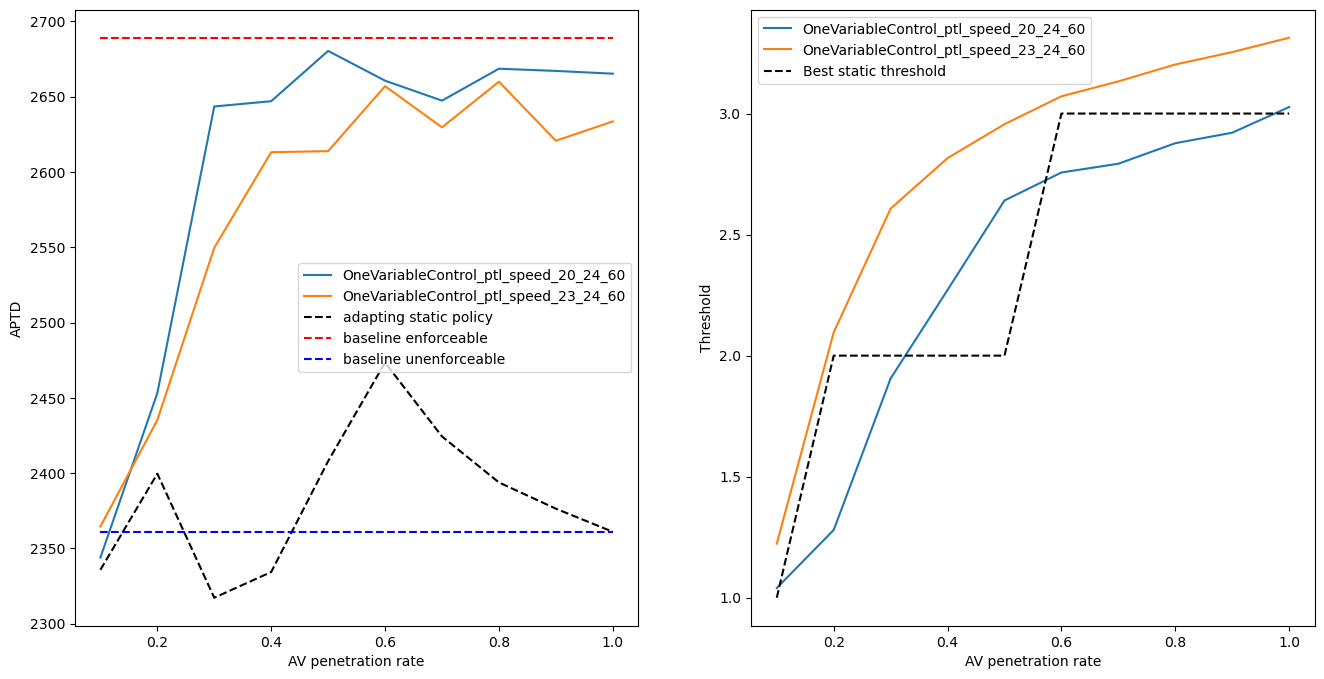

In [14]:
# reading APTD df
demand_cols = [c for c in aptd_df.columns if demand in c and "mean" in c and 0.0 not in c]

# getting baseline values
baseline_enforceable = min(aptd_df[(demand,0.0,"mean")].loc[["Nothing","Plus_1"]])
baseline_unenforceable = min(aptd_df[(demand,0.0,"mean")])

# getting the best static policy and its values
static_polices = [f"StaticNumPass_{i}" for i in range(1,6)]
best_changing_static = aptd_df[demand_cols].loc[static_polices].min(axis=0).values
idx_changing_static = aptd_df[demand_cols].loc[static_polices].idxmin(axis=0).apply(lambda x: x.split("_")[1]).values

# getting the dynamic policies and their values
dynamic_policies = aptd_df.index[aptd_df.index.str.contains("OneVariable")& aptd_df.index.str.contains("60") & ~aptd_df.index.str.contains("18") ].tolist()
dynamic_policies = aptd_df[demand_cols].loc[dynamic_policies]

# getting the dynmaic policies thresholds
policies_thresholds = threshold_df.loc[dynamic_policies.index][demand_cols]

# plot the APTD of the dynamic policies, the best static policy and the baseline
fig, axs = plt.subplots(1,2)
fig.set_size_inches(16,8)
for policy in dynamic_policies.index:
    axs[0].plot(av_rates,dynamic_policies.loc[policy],label=policy)
    axs[1].plot(av_rates,policies_thresholds.loc[policy].values,label=policy)
axs[0].plot(av_rates,best_changing_static,color="black",linestyle="--",label="adapting static policy")
axs[0].plot(av_rates,[baseline_enforceable]*10,color="red",linestyle="--",label="baseline enforceable")
axs[0].plot(av_rates,[baseline_unenforceable]*10,color="blue",linestyle="--",label="baseline unenforceable")

axs[1].plot(av_rates,idx_changing_static.astype(float),color="black",linestyle="--",label="Best static threshold")
axs[0].set_xlabel("AV penetration rate")
axs[0].set_ylabel("APTD")
axs[1].set_xlabel("AV penetration rate")
axs[1].set_ylabel("Threshold")
axs[0].legend()
axs[1].legend()

plt.show()

# Total delay for Toy3000 staticnumpass 1

In [118]:
total_delay = pd.read_pickle(r"C:\PTL\results\output_results\network_simple\ToyPaper\totalDelay.pkl")
demand = "ToyPaper_3000"
policy = "StaticNumPass_1"
demand_cols = [c for c in total_delay.columns if demand in c and 0.0 not in c]

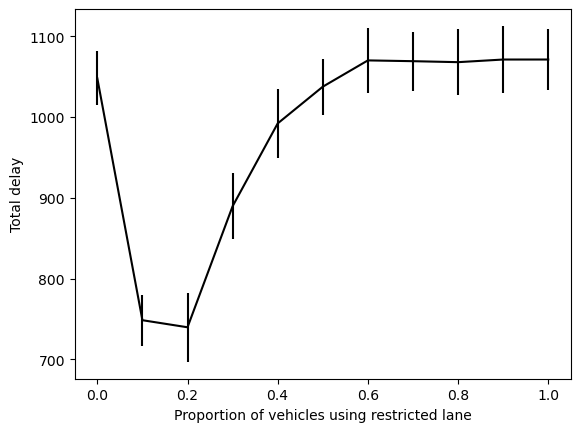

In [128]:
rel_df = total_delay[demand_cols].loc[policy].reset_index()
zero_enterance = total_delay.loc["NoBody"].reset_index()["NoBody"].values[:2]
rel_df.columns = ["demand","av_rate","mean/std","total_delay"]
mean_values = [zero_enterance[0]] +rel_df[rel_df["mean/std"]=="mean"]["total_delay"].values.tolist()
mean_values = np.array(mean_values)
std_values = [zero_enterance[1]]+rel_df[rel_df["mean/std"]=="std"]["total_delay"].values.tolist()
std_values = np.array(std_values)
av_rates = [0.0] + rel_df[rel_df["mean/std"]=="mean"]["av_rate"].values.tolist()
plt.errorbar(av_rates,mean_values,yerr=1.96*std_values/np.sqrt(10), color="black")
plt.xlabel("Proportion of vehicles using restricted lane")
plt.ylabel("Total delay")
plt.show()

# Speeds along different penetration rates

In [129]:
import pickle
from results.parse_exp_results import ResultsParser
import os
import numpy as np

In [130]:
seeds = os.listdir(r"C:\PTL\SUMO\outputs\network_simple\ToyPaper_3000\0.1")
demand = "ToyPaper_3000"
def preprocess(av_rate,policy):
    rps = [pickle.load(open(rf"C:\PTL\SUMO\outputs\network_simple\{demand}\{av_rate}\{seed}\{policy}_ResultsParser.pkl", "rb")).speed_df.astype(float).mean().values.tolist() for seed in seeds]
    return np.array(rps).mean(axis=0)

In [131]:
rp_00 = preprocess("0.0","NoBody")
rp_02 = preprocess("0.1","StaticNumPass_1")
rp_04 = preprocess("0.4","StaticNumPass_1")
rp_1 = preprocess("1.0","StaticNumPass_1")

In [132]:
counts = [rp_00, rp_02, rp_04, rp_1]
names = ["0% allowed", "20% allowed", "40% allowed", "100% allowed"]

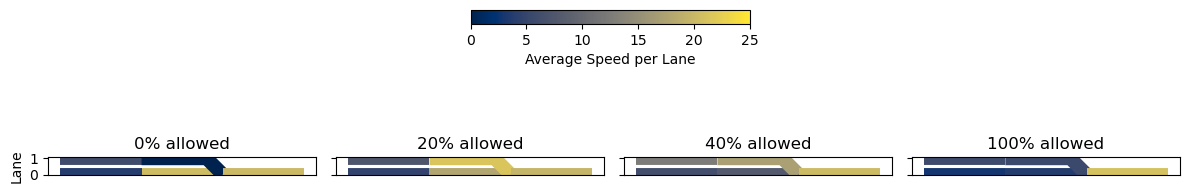

In [133]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def plot_lanes_behaviour(vehicle_counts, names):

    # Define road network coordinates with more complexity
    lane0_segment1 = [(0, 0), (5, 0)]  # Right lane, first segment
    lane1_segment1 = [(0, 1), (5, 1)]  # Left lane, first segment
    lane0_segment2 = [(5, 0), (10, 0)]  # Right lane, second segment
    lane1_segment2 = [(5, 1), (9, 1), (10,0)]  # Left lane, second segment
    last_lane = [(10, 0), (15, 0)]  # Single merged lane
    
    lanes = [lane0_segment1, lane1_segment1, lane0_segment2, lane1_segment2, last_lane]
    
    # Normalize across all scenarios for consistent color mapping
    all_vehicle_counts = [count for counts in vehicle_counts for count in counts]
    norm = mcolors.Normalize(vmin=0, vmax=25)
    cmap = cm.get_cmap('cividis')
    
    # Create plots
    fig, axs = plt.subplots(1, len(names), figsize=(12, 8), sharey=True)
    
    for ax, vehicle_counts, title in zip(
        axs, vehicle_counts,names
    ):
        # Map vehicle counts to colors
        colors = [cmap(norm(count)) for count in vehicle_counts]
    
        # Create a LineCollection with the mapped colors
        line_segments = LineCollection(lanes, colors=colors, linewidths=10)
    
        # Plotting the road network
        ax.add_collection(line_segments)
        ax.autoscale()
        ax.set_aspect('equal')
        ax.set_title(title)
        # ax.set_xlabel("X Coordinate")
        ax.set_xticks([])
    
    axs[0].set_ylabel("Lane")
    
    # Add a shared colorbar for all subplots
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array(all_vehicle_counts)
    cbar = fig.colorbar(sm, ax=axs, orientation='horizontal', label='Average Speed per Lane', shrink=0.3)
    
    # Adjust layout and show the plot
    plt.tight_layout()  # Add space for the top colorbar
    plt.show()

plot_lanes_behaviour(counts, names)